# Model 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import scipy
import datetime
from itertools import cycle
import json

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix, PrecisionRecallDisplay, precision_recall_curve

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.metrics import Precision, Recall, Accuracy, PrecisionAtRecall, AUC

# from sklearnex import patch_sklearn
# patch_sklearn()

2022-10-15 09:18:55.459023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 09:18:55.883516: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-15 09:18:56.795110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bryan/miniconda3/envs/tf/lib/
2022-10-15 09:18:56.795241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
# Read in the pickle file

with open('../pickled_models/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under username h...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,aww match this background colour seemingly sti...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man really not try edit war just that this...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more cannot make any real suggestions improvem...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir hero any chance you remember what page...


# Train test split

In [3]:
# Taking a subset of the data for faster processing

# df_train = df_train.sample(1000, random_state=42)

In [4]:
# train test split

features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X = df_train["cleaned_comment_text"].to_numpy()
y = df_train[features].to_numpy()

# X_train, y_train, X_test, y_test = iterative_train_test_split(
#     X.values.reshape(-1, 1), y.values, test_size=0.3,
# )

msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

for train_index, test_index in msss.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

TRAIN: [     0      1      3 ... 159567 159568 159570] TEST: [     2      5      8 ... 159556 159562 159569]
TRAIN: [     0      1      2 ... 159567 159569 159570] TEST: [     3      4     10 ... 159559 159565 159568]


In [5]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(111699,)

(111699, 6)

(47872,)

(47872, 6)

# scikit-learn estimators that have multi-learning support built-in


# Multioutput classifier

In [83]:
# import the best estimator from the chosen LinearSVC model

with open('../pickled_models/final_split_results.pickle', 'rb') as f:
    results = pickle.load(f)

In [97]:
with pd.option_context("display.max_colwidth", None):
    display(results.query("metric == 'average_precision' and index.str.contains('svc')", engine='python')['best_params'].reset_index())

,index,best_params
0,30,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}"
1,31,"{'svc__C': 0.01, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}"
2,32,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}"
3,33,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}"
4,34,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}"
5,35,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__max_iter': 10000, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}"


In [104]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.9, max_features=5000)),
    ('log', MultiOutputClassifier(LinearSVC(class_weight='balanced', max_iter=10_000,C=0.1), n_jobs=-1)),
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 MultiOutputClassifier(estimator=LinearSVC(C=0.1,
                                                           class_weight='balanced',
                                                           max_iter=10000),
                                       n_jobs=-1))])

In [106]:
with open('../pickled_models/combined/multioutput_svc.pickle', 'wb') as f:
    pickle.dump(pipe_svc, f)

In [35]:
with open('../pickled_models/combined/multioutput_svc.pickle', 'rb') as f:
    pipe_svc = pickle.load(f)

In [36]:
y_pred = pipe_svc.predict(X_test.ravel())

In [37]:
print(classification_report(y_test, y_pred, target_names=features))

               precision    recall  f1-score   support

        toxic       0.59      0.85      0.69      4588
 severe_toxic       0.22      0.89      0.36       479
      obscene       0.63      0.88      0.73      2535
       threat       0.16      0.74      0.26       143
       insult       0.48      0.86      0.62      2363
identity_hate       0.16      0.79      0.26       422

    micro avg       0.47      0.86      0.61     10530
    macro avg       0.37      0.83      0.49     10530
 weighted avg       0.53      0.86      0.65     10530
  samples avg       0.06      0.08      0.06     10530



/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


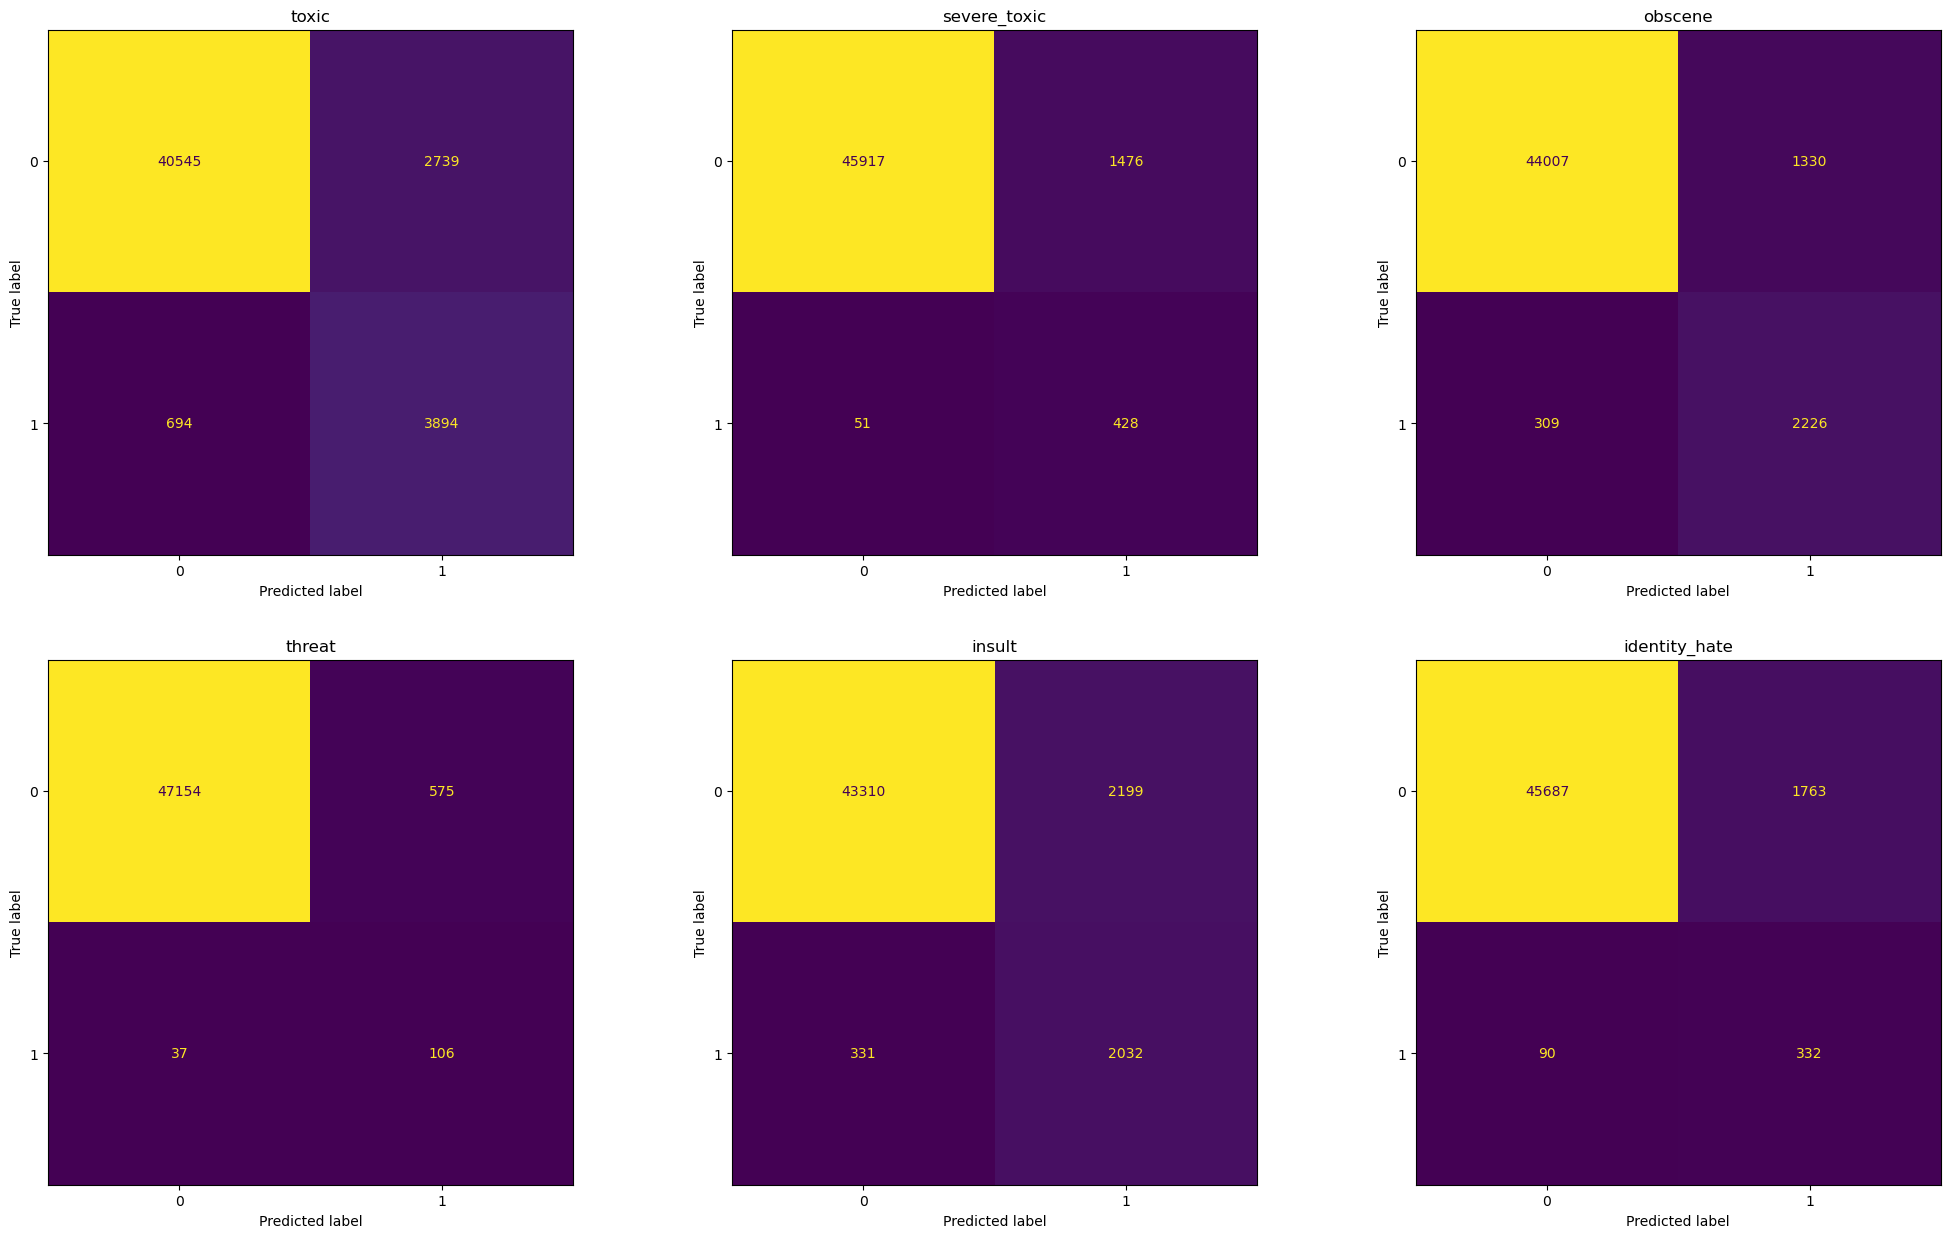

In [38]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

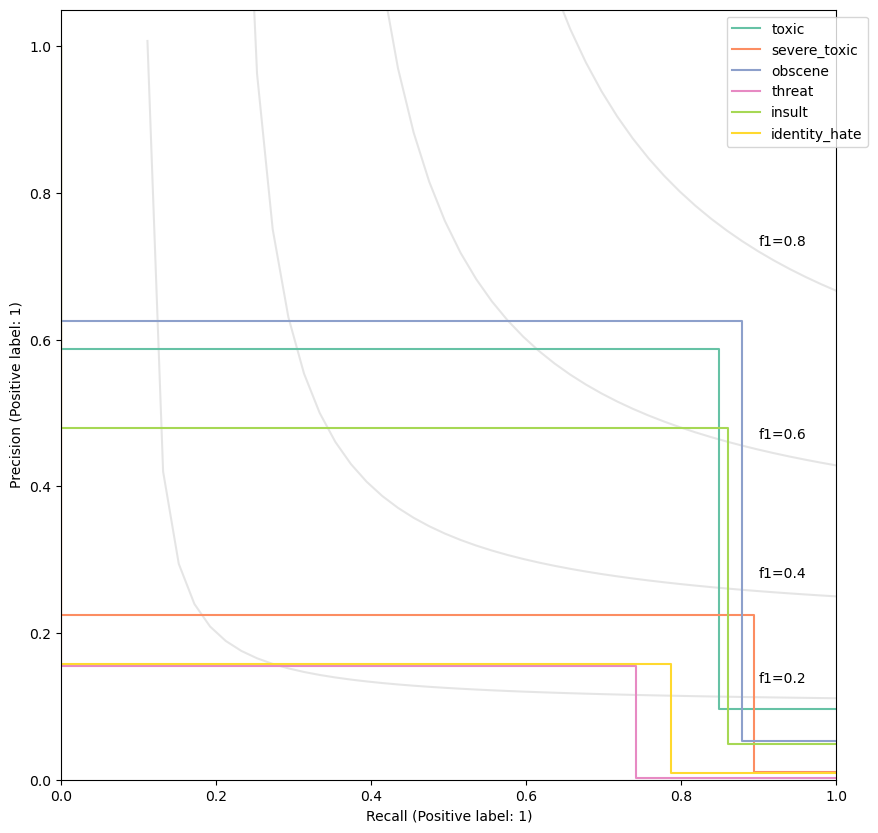

In [60]:
f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

# ClassifierChain

In [24]:
pipe_cc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.9, max_features=5000)),
    ('cc', ClassifierChain(LinearSVC(class_weight='balanced', max_iter=10_000,C=0.1), order='random', random_state=42)),
])

pipe_cc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 ClassifierChain(base_estimator=LinearSVC(C=0.1,
                                                          class_weight='balanced',
                                                          max_iter=10000),
                                 order='random', random_state=42))])

In [25]:
with open('../pickled_models/combined/classifierchain_svc.pickle', 'wb') as f:
    pickle.dump(pipe_cc, f)

In [61]:
with open('../pickled_models/combined/classifierchain_svc.pickle', 'rb') as f:
    pipe_cc = pickle.load(f)

In [62]:
y_pred = pipe_cc.predict(X_test.ravel())

In [63]:
print(classification_report(y_test, y_pred, target_names=features))

               precision    recall  f1-score   support

        toxic       0.59      0.85      0.69      4588
 severe_toxic       0.16      0.92      0.27       479
      obscene       0.38      0.93      0.54      2535
       threat       0.07      0.82      0.14       143
       insult       0.34      0.93      0.50      2363
identity_hate       0.11      0.85      0.20       422

    micro avg       0.35      0.89      0.50     10530
    macro avg       0.28      0.88      0.39     10530
 weighted avg       0.44      0.89      0.57     10530
  samples avg       0.05      0.08      0.06     10530



/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


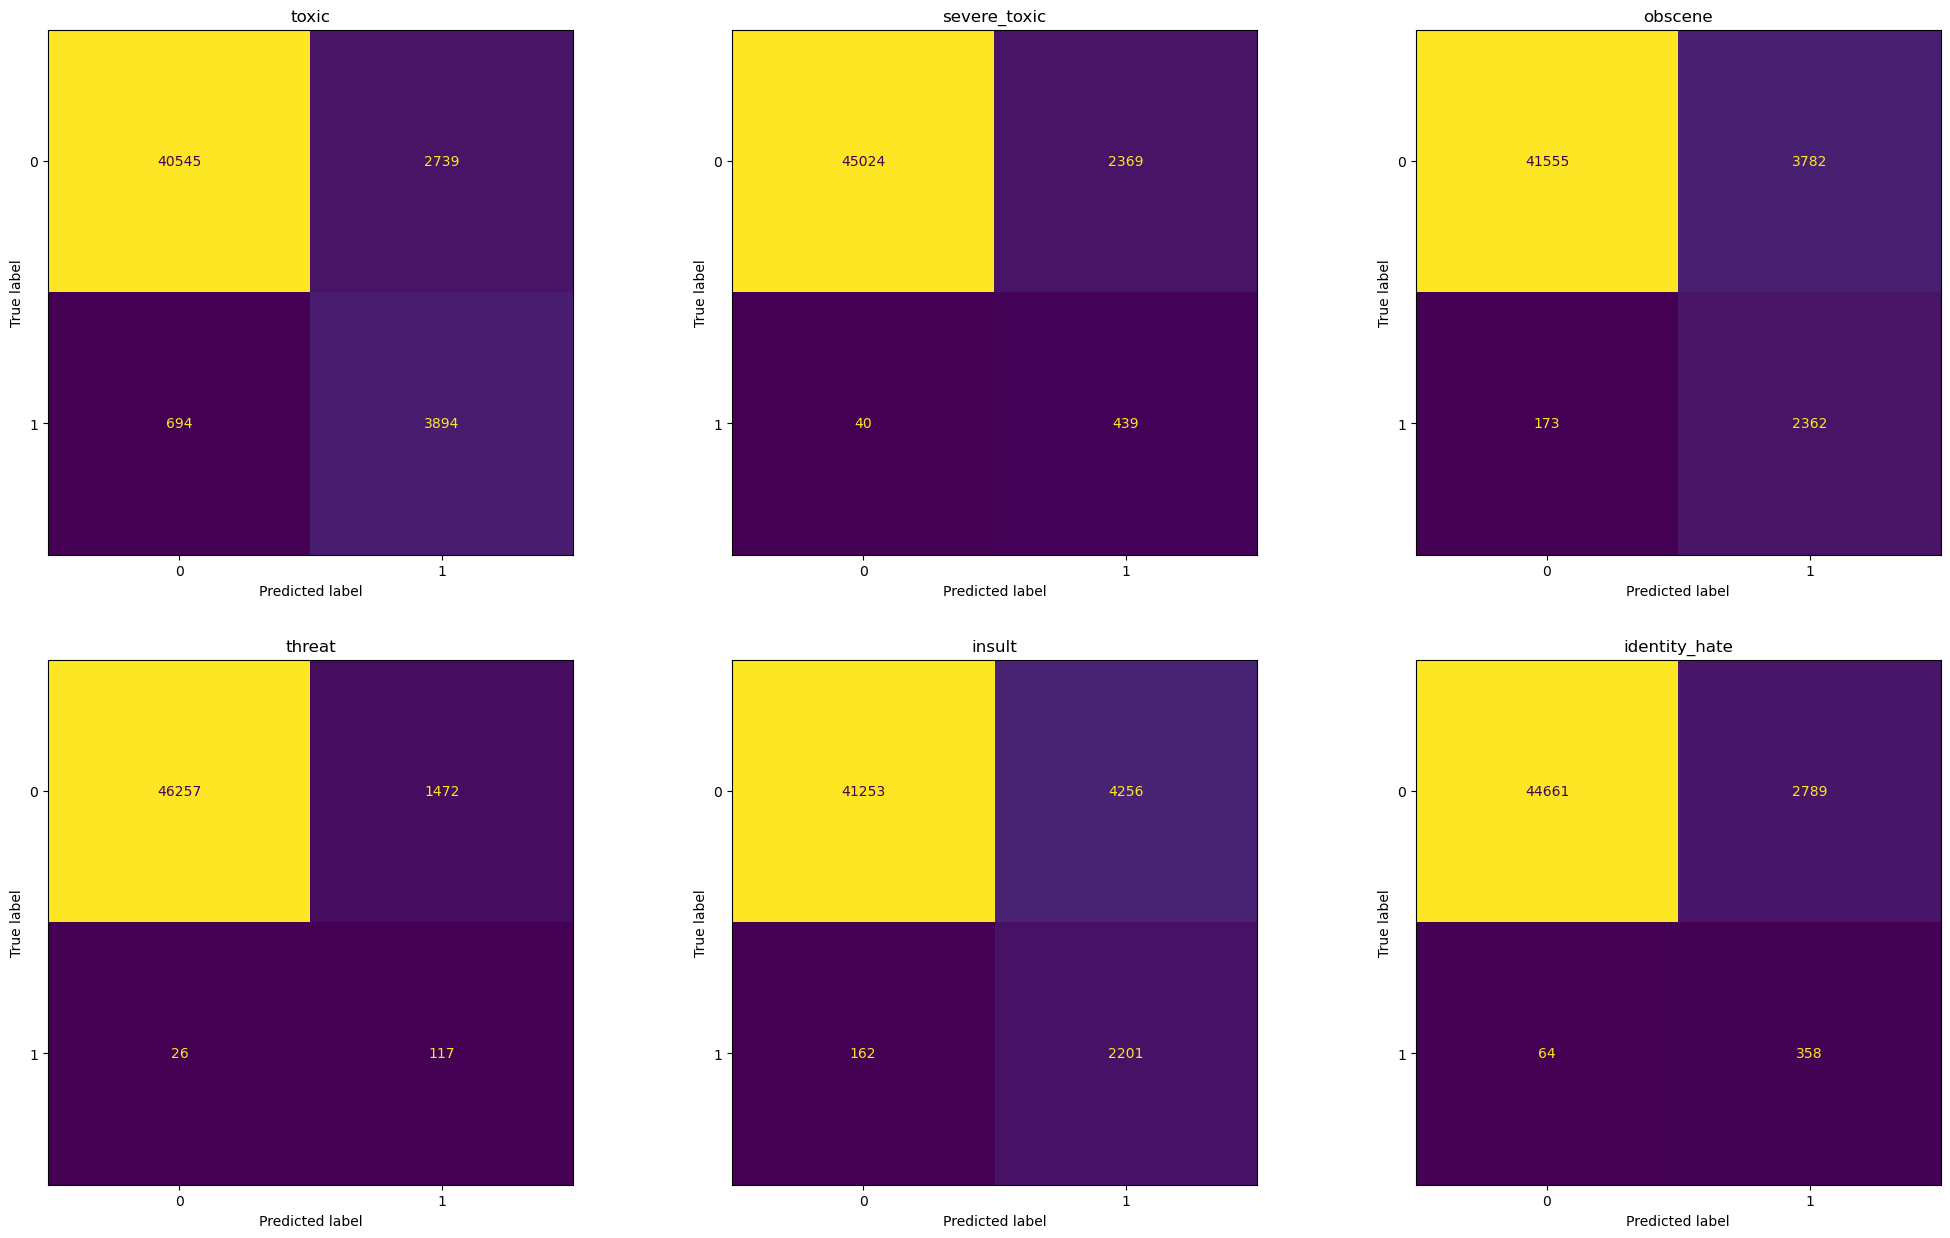

In [64]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

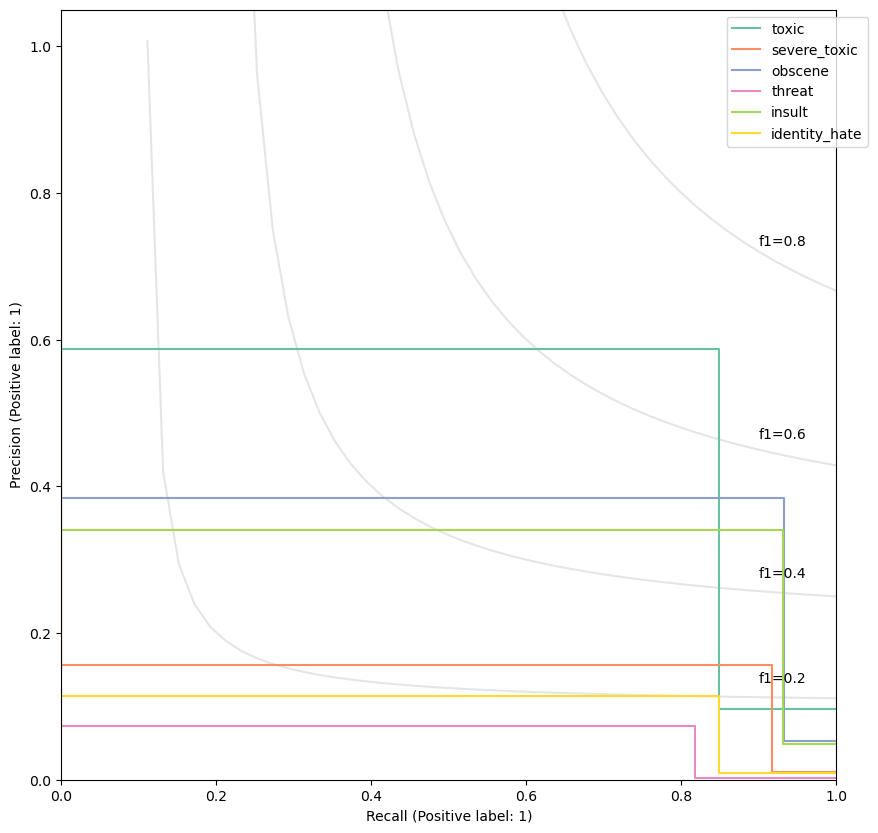

In [65]:
f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

# Trying out the adapted algorithm

## Label Powerset

In [29]:
pipe_lb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.9, max_features=5000)),
    ('cc', LabelPowerset(LinearSVC(class_weight='balanced', max_iter=10_000,C=0.1))),
])

pipe_lb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('cc',
                 LabelPowerset(classifier=LinearSVC(C=0.1,
                                                    class_weight='balanced',
                                                    max_iter=10000),
                               require_dense=[True, True]))])

In [30]:
with open('../pickled_models/combined/labelpowerset_svc.pickle', 'wb') as f:
    pickle.dump(pipe_lb, f)

In [31]:
y_pred = pipe_cc.predict(X_test.ravel())

In [66]:
with open('../pickled_models/combined/labelpowerset_svc.pickle', 'rb') as f:
    pipe_lb = pickle.load(f)

In [67]:
print(classification_report(y_test, y_pred, target_names=features))

               precision    recall  f1-score   support

        toxic       0.59      0.85      0.69      4588
 severe_toxic       0.16      0.92      0.27       479
      obscene       0.38      0.93      0.54      2535
       threat       0.07      0.82      0.14       143
       insult       0.34      0.93      0.50      2363
identity_hate       0.11      0.85      0.20       422

    micro avg       0.35      0.89      0.50     10530
    macro avg       0.28      0.88      0.39     10530
 weighted avg       0.44      0.89      0.57     10530
  samples avg       0.05      0.08      0.06     10530



/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


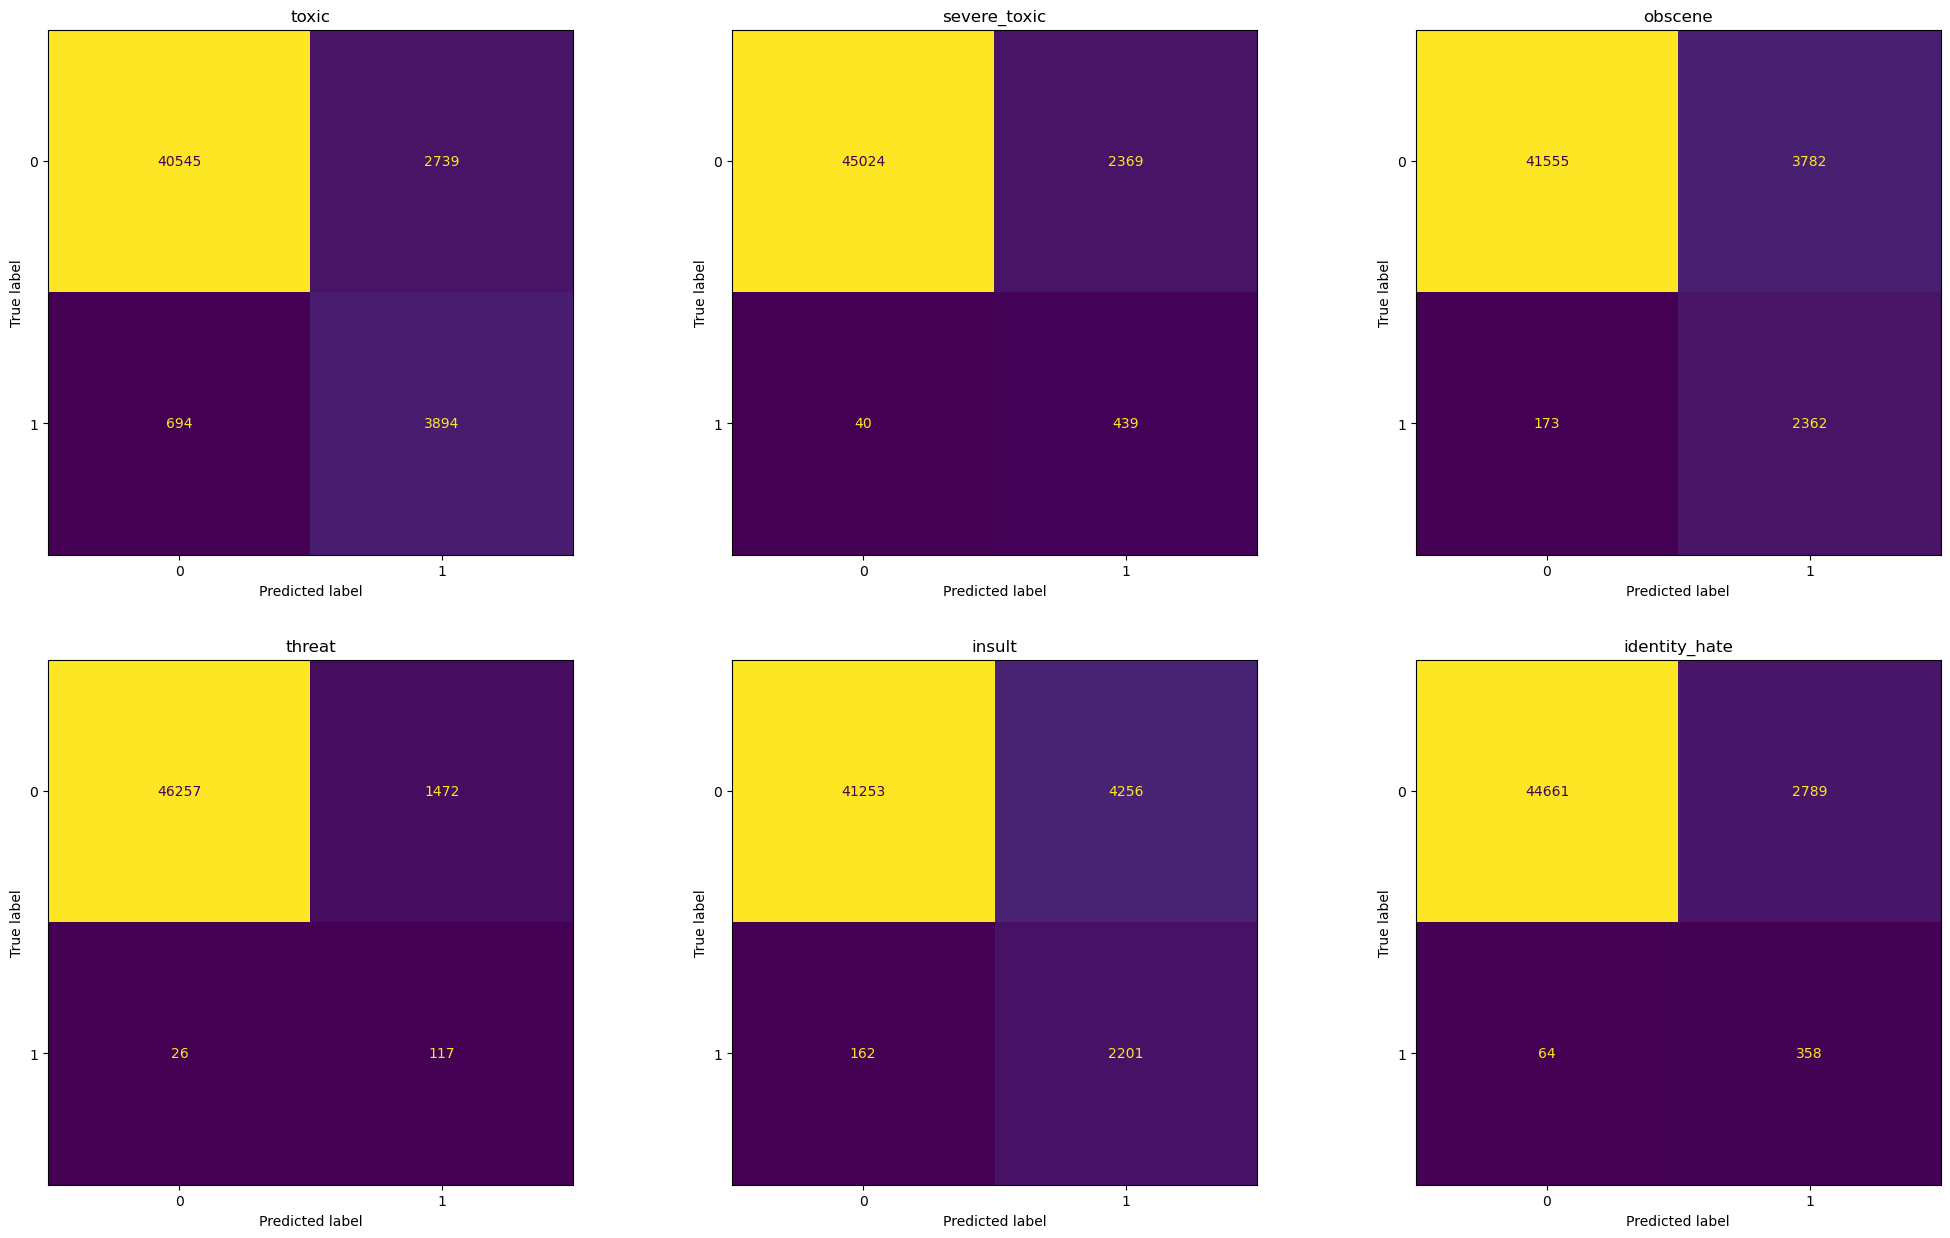

In [68]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

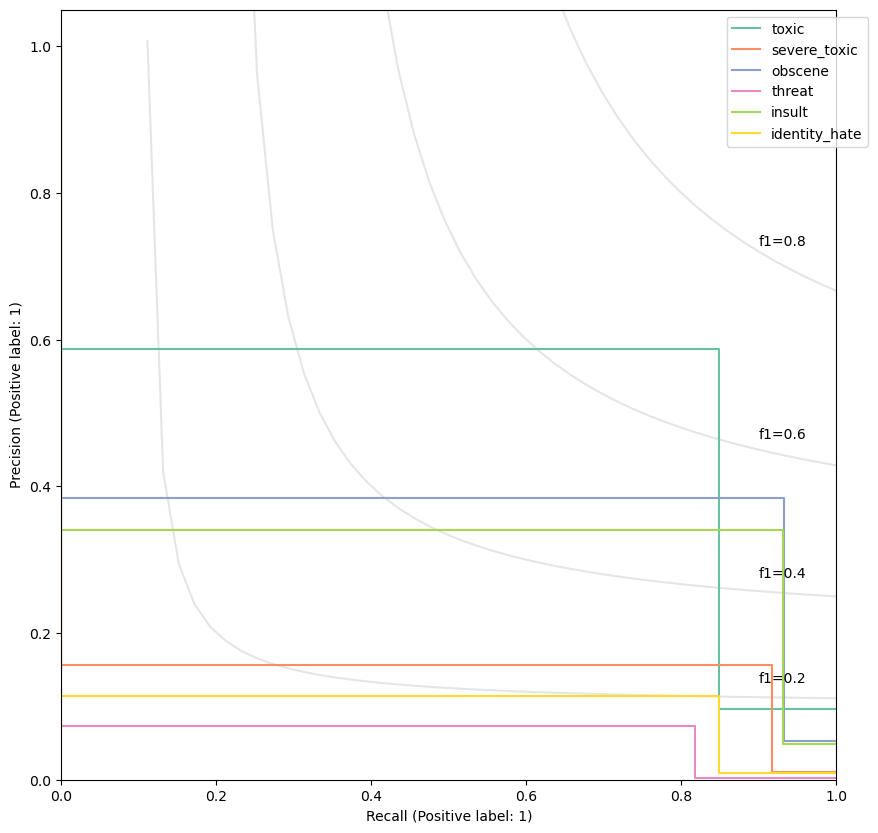

In [69]:
f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

# Neural Network

## All together

In [6]:
# # train test split

# features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# X = df_train["cleaned_comment_text"].to_numpy()
# y = df_train[features].to_numpy()

# # X_train, y_train, X_test, y_test = iterative_train_test_split(
# #     X.values.reshape(-1, 1), y.values, test_size=0.3,
# # )

# msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

# for train_index, test_index in msss.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

In [7]:
# display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [6]:
# Configuration for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-15 09:19:03.895780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:03.926305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:03.926581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
# Text vectorization - similar to vectoriser in sklearn for text, placing max features to be 20000 and the max length of each text to be 100
max_features = 20000
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=100)

2022-10-15 09:19:04.794502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 09:19:04.795508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:04.795863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:04.796064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
# adapt the vectorizer to the text like fit in sklearn
vectorizer.adapt(X_train.ravel())

In [9]:
# transforming the text to vectors like transform in sklearn
vectorized_X_train = vectorizer(X_train.ravel())
vectorized_X_test = vectorizer(X_test.ravel())

## Deep learning

In [12]:
def nn_creation():
    # Neural network creation
    model = Sequential()
    # Create the emedding layer
    model.add(Embedding(max_features+1, 128))
    # Create the LSTM layer
    model.add(Bidirectional(LSTM(60, return_sequences=True, dropout=0.1)))
    model.add(GlobalMaxPool1D())

    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    # Final layer
    model.add(Dense(6, activation='sigmoid'))

    # Define the metrics
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

    return model

In [13]:
model = nn_creation()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 bidirectional (Bidirectiona  (None, None, 120)        90720     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 120)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                6050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [15]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-10-15 09:19:30.123287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:30.123579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:30.123737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:30.123934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 09:19:30.124090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Tensorboard extension configuration

In [13]:
%load_ext tensorboard

In [14]:
log_dir = "logs/fit/base_model" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
EPOCHS = 100

history_first = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=1024, verbose=1, callbacks=[tensorboard_callback])

# Large batch size used so that each batch will contain the negative classes. If the batch size is small, the batch will contain only the negative classes and the model will not learn anything.

Epoch 1/100


2022-10-14 23:21:26.553322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


110/110 [==============================] - ETA: 0s - loss: 0.2195 - tp: 252.0000 - fp: 6970.0000 - tn: 638656.0000 - fn: 24316.0000 - accuracy: 0.9533 - precision: 0.0349 - recall: 0.0103 - auc: 0.6427 - prc: 0.0487

2022-10-14 23:21:39.536267: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 20s 102ms/step - loss: 0.2195 - tp: 252.0000 - fp: 6970.0000 - tn: 638656.0000 - fn: 24316.0000 - accuracy: 0.9533 - precision: 0.0349 - recall: 0.0103 - auc: 0.6427 - prc: 0.0487 - val_loss: 0.1218 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 276702.0000 - val_fn: 10530.0000 - val_accuracy: 0.9633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8809 - val_prc: 0.3414
Epoch 2/100
110/110 [==============================] - 7s 60ms/step - loss: 0.0928 - tp: 5151.0000 - fp: 1267.0000 - tn: 644359.0000 - fn: 19417.0000 - accuracy: 0.9691 - precision: 0.8026 - recall: 0.2097 - auc: 0.9240 - prc: 0.5289 - val_loss: 0.0647 - val_tp: 5687.0000 - val_fp: 1342.0000 - val_tn: 275360.0000 - val_fn: 4843.0000 - val_accuracy: 0.9785 - val_precision: 0.8091 - val_recall: 0.5401 - val_auc: 0.9717 - val_prc: 0.7389
Epoch 3/100


2022-10-14 23:21:46.186611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 60ms/step - loss: 0.0546 - tp: 15345.0000 - fp: 3829.0000 - tn: 641797.0000 - fn: 9223.0000 - accuracy: 0.9805 - precision: 0.8003 - recall: 0.6246 - auc: 0.9770 - prc: 0.7837 - val_loss: 0.0514 - val_tp: 7020.0000 - val_fp: 1854.0000 - val_tn: 274848.0000 - val_fn: 3510.0000 - val_accuracy: 0.9813 - val_precision: 0.7911 - val_recall: 0.6667 - val_auc: 0.9779 - val_prc: 0.8066
Epoch 4/100


2022-10-14 23:21:52.788449: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 60ms/step - loss: 0.0464 - tp: 16973.0000 - fp: 3903.0000 - tn: 641723.0000 - fn: 7595.0000 - accuracy: 0.9828 - precision: 0.8130 - recall: 0.6909 - auc: 0.9832 - prc: 0.8297 - val_loss: 0.0504 - val_tp: 6905.0000 - val_fp: 1552.0000 - val_tn: 275150.0000 - val_fn: 3625.0000 - val_accuracy: 0.9820 - val_precision: 0.8165 - val_recall: 0.6557 - val_auc: 0.9769 - val_prc: 0.8130


2022-10-14 23:21:59.414579: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


Epoch 5/100
110/110 [==============================] - 7s 61ms/step - loss: 0.0429 - tp: 17523.0000 - fp: 3761.0000 - tn: 641865.0000 - fn: 7045.0000 - accuracy: 0.9839 - precision: 0.8233 - recall: 0.7132 - auc: 0.9857 - prc: 0.8493 - val_loss: 0.0508 - val_tp: 7135.0000 - val_fp: 1838.0000 - val_tn: 274864.0000 - val_fn: 3395.0000 - val_accuracy: 0.9818 - val_precision: 0.7952 - val_recall: 0.6776 - val_auc: 0.9774 - val_prc: 0.8120
Epoch 6/100


2022-10-14 23:22:06.119120: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 61ms/step - loss: 0.0408 - tp: 17954.0000 - fp: 3781.0000 - tn: 641845.0000 - fn: 6614.0000 - accuracy: 0.9845 - precision: 0.8260 - recall: 0.7308 - auc: 0.9874 - prc: 0.8595 - val_loss: 0.0518 - val_tp: 7018.0000 - val_fp: 1701.0000 - val_tn: 275001.0000 - val_fn: 3512.0000 - val_accuracy: 0.9819 - val_precision: 0.8049 - val_recall: 0.6665 - val_auc: 0.9717 - val_prc: 0.8095
Epoch 7/100
110/110 [==============================] - 7s 64ms/step - loss: 0.0386 - tp: 18417.0000 - fp: 3635.0000 - tn: 641991.0000 - fn: 6151.0000 - accuracy: 0.9854 - precision: 0.8352 - recall: 0.7496 - auc: 0.9892 - prc: 0.8709 - val_loss: 0.0568 - val_tp: 6995.0000 - val_fp: 1717.0000 - val_tn: 274985.0000 - val_fn: 3535.0000 - val_accuracy: 0.9817 - val_precision: 0.8029 - val_recall: 0.6643 - val_auc: 0.9580 - val_prc: 0.7978
Epoch 8/100
110/110 [==============================] - 7s 60ms/step - loss: 0.0371 - tp: 18670.0000 - fp: 3576.0000 - tn: 642050.0000 

In [22]:
model.save('../nn_models/baseline_model_1024batch.h5')

In [118]:
# %tensorboard --logdir logs/fit/base_model

In [23]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_first.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_1024", 'w'))

In [63]:
history_dict = json.load(open("../nn_models/saved_history_1024", 'r'))

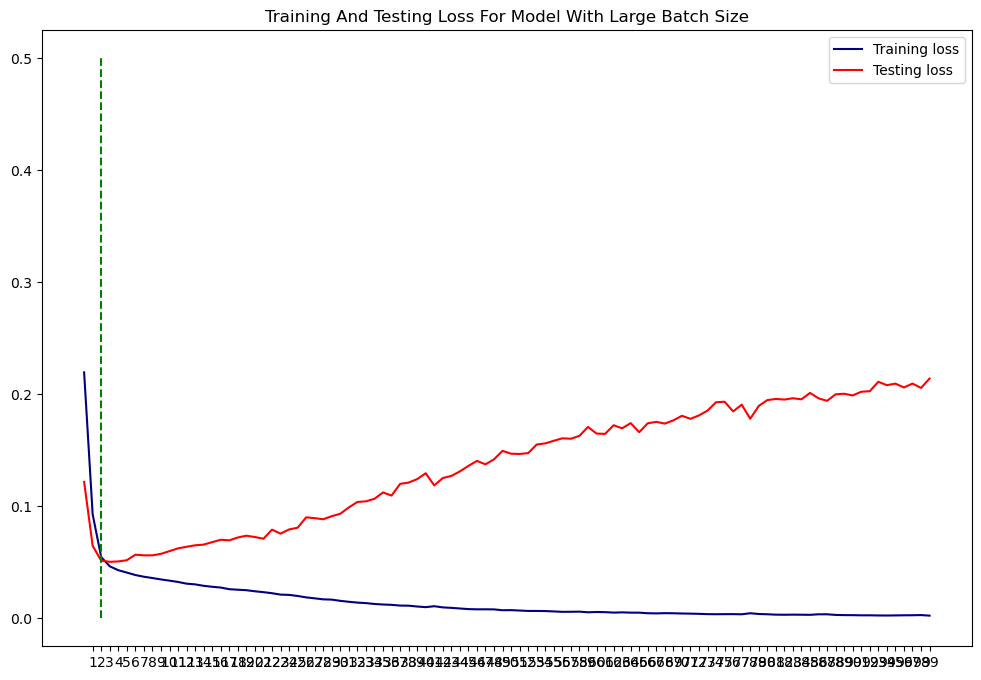

In [67]:
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.vlines(x=2, ymin=0, ymax=0.5, color='green', linestyle='--')
plt.title('Training and Testing Loss for model with large batch size'.title())
plt.legend()
plt.xticks(range(1, 100, 1))
plt.savefig('../charts/baseline_model_loss.png', bbox_inches='tight')
plt.show()

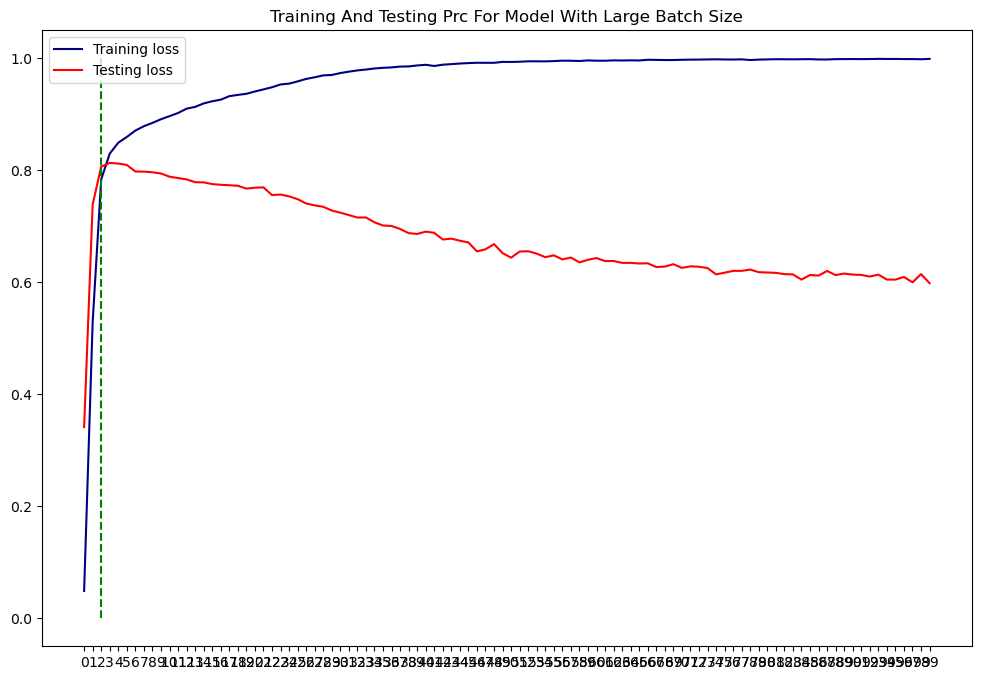

In [69]:
train_loss = history_dict['prc']
test_loss = history_dict['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.title('Training and Testing prc for model with large batch size'.title())
plt.vlines(x=2, ymin=0, ymax=1.0, color='green', linestyle='--')
plt.legend()
plt.xticks(range(0, 100, 1))
plt.savefig('../charts/baseline_model_prc.png', bbox_inches='tight')
plt.show()

In [27]:
# model = keras.models.load_model("../nn_models/baseline_model.h5")

In [91]:
# y_pred = model.predict(vectorized_X_test, batch_size=2048)

# predict the test data and change the values to binary
y_pred = (model.predict(vectorized_X_test, batch_size=2048) > 0.5).astype("int32")

24/24 [==============================] - 1s 30ms/step


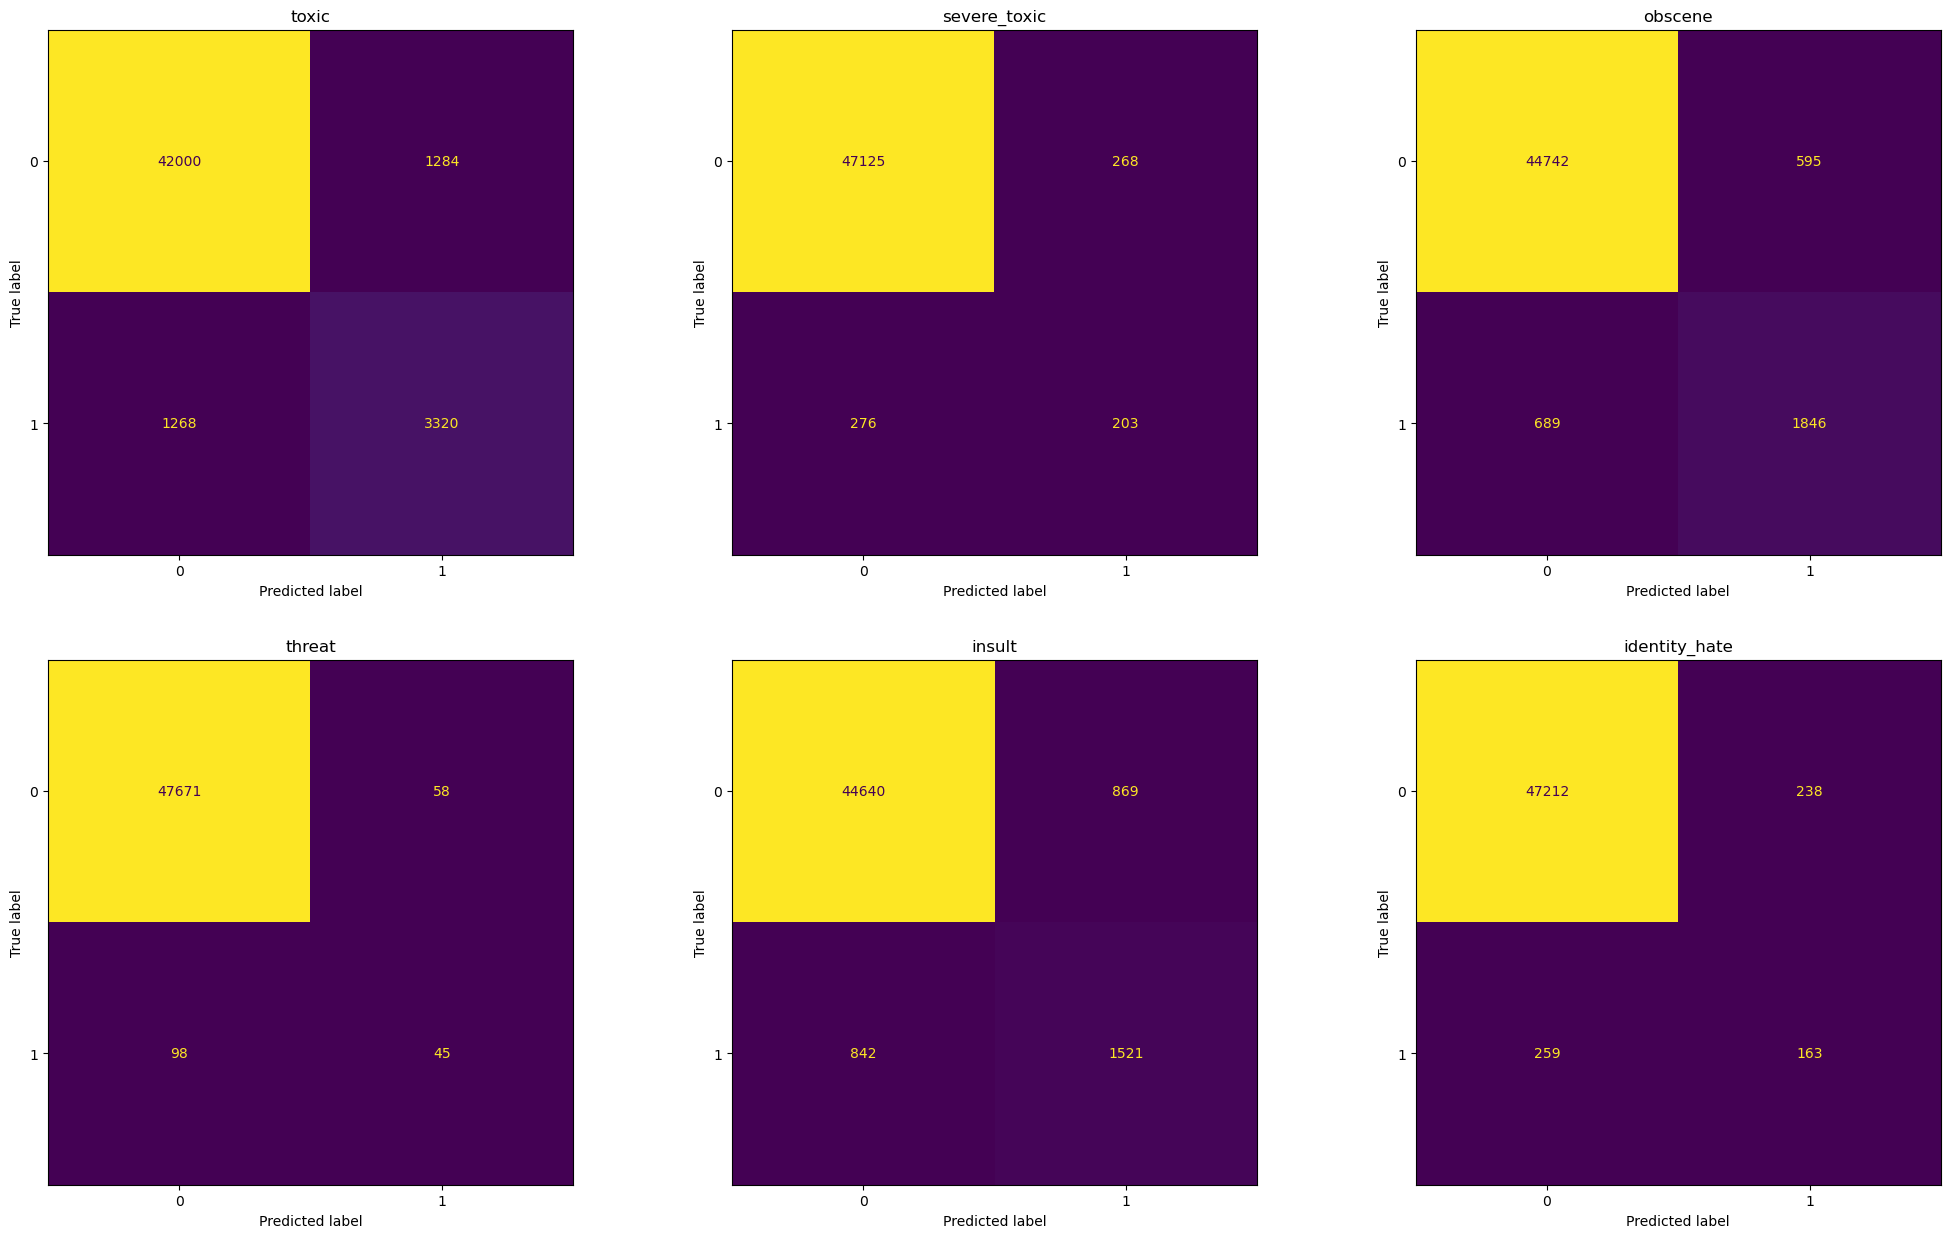

In [95]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

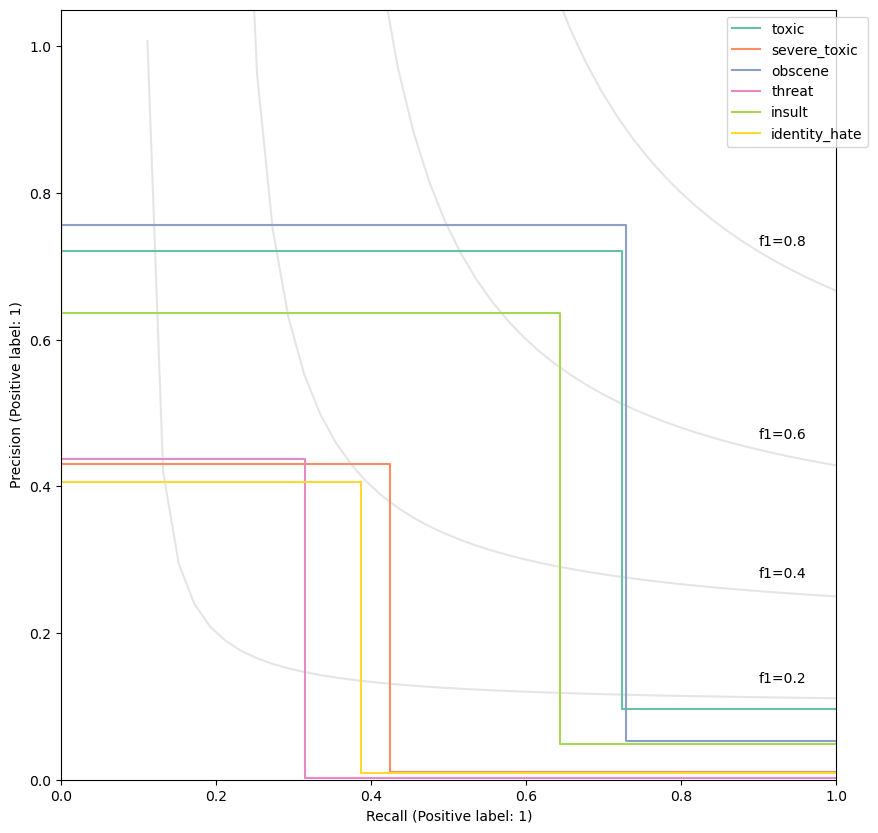

In [96]:
f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

# Model with class weights

In [20]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
    """
    Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
    Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
    The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
    of appareance of the label when the dataset was processed.
    In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
    Author: Angel Igareta (angel@igareta.com)
    """
    if multi_class:
        # If class is one hot encoded, transform to categorical labels to use compute_class_weight
        if one_hot_encoded:
            class_series = np.argmax(class_series, axis=1)

        # Compute class weights with sklearn method
        class_labels = np.unique(class_series)
        class_weights = compute_class_weight(
            class_weight="balanced", classes=class_labels, y=class_series
        )
        return dict(zip(class_labels, class_weights))
    else:
        # It is neccessary that the multi-label values are one-hot encoded
        mlb = None
        if not one_hot_encoded:
            mlb = MultiLabelBinarizer()
            class_series = mlb.fit_transform(class_series)

        n_samples = len(class_series)
        n_classes = len(class_series[0])

        # Count each class frequency
        class_count = [0] * n_classes
        for classes in class_series:
            for index in range(n_classes):
                if classes[index] != 0:
                    class_count[index] += 1

        # Compute class weights using balanced method
        class_weights = [
            n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count
        ]
        class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
        return dict(zip(class_labels, class_weights))

In [21]:
class_weights = generate_class_weights(y_train, multi_class=False, one_hot_encoded=True)

In [22]:
class_weights

{0: 1.7388847375303569,
 1: 16.681451612903224,
 2: 3.1478694622928645,
 3: 55.571641791044776,
 4: 3.3762241566920568,
 5: 18.938453713123092}

In [31]:
log_dir2 = "logs/fit/model_class_weights" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [32]:
model = nn_creation()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 50)                6050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                

In [34]:
EPOCHS = 100

history_class_weights = model.fit(
    vectorized_X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(vectorized_X_test, y_test),
    batch_size=1024,
    verbose=1,
    callbacks=[tensorboard_callback],
    class_weight=class_weights,
)

Epoch 1/100
110/110 [==============================] - 7s 64ms/step - loss: 0.0673 - tp: 19129.0000 - fp: 3263.0000 - tn: 642363.0000 - fn: 5439.0000 - accuracy: 0.9870 - precision: 0.8543 - recall: 0.7786 - auc: 0.9926 - prc: 0.8991 - val_loss: 0.0587 - val_tp: 7069.0000 - val_fp: 2111.0000 - val_tn: 274591.0000 - val_fn: 3461.0000 - val_accuracy: 0.9806 - val_precision: 0.7700 - val_recall: 0.6713 - val_auc: 0.9576 - val_prc: 0.7882
Epoch 2/100
110/110 [==============================] - 8s 71ms/step - loss: 0.0632 - tp: 19477.0000 - fp: 3147.0000 - tn: 642479.0000 - fn: 5091.0000 - accuracy: 0.9877 - precision: 0.8609 - recall: 0.7928 - auc: 0.9941 - prc: 0.9081 - val_loss: 0.0589 - val_tp: 7061.0000 - val_fp: 2176.0000 - val_tn: 274526.0000 - val_fn: 3469.0000 - val_accuracy: 0.9803 - val_precision: 0.7644 - val_recall: 0.6706 - val_auc: 0.9597 - val_prc: 0.7871
Epoch 3/100
110/110 [==============================] - 7s 66ms/step - loss: 0.0611 - tp: 19702.0000 - fp: 3044.0000 - tn: 

In [35]:
model.save('../nn_models/baseline_model_class_weights.h5')

In [36]:
# %tensorboard --logdir logs/fit/

In [37]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_class_weights.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_class_weights", 'w'))

In [76]:
history_class_weights = json.load(open("../nn_models/saved_history_class_weights", 'r'))

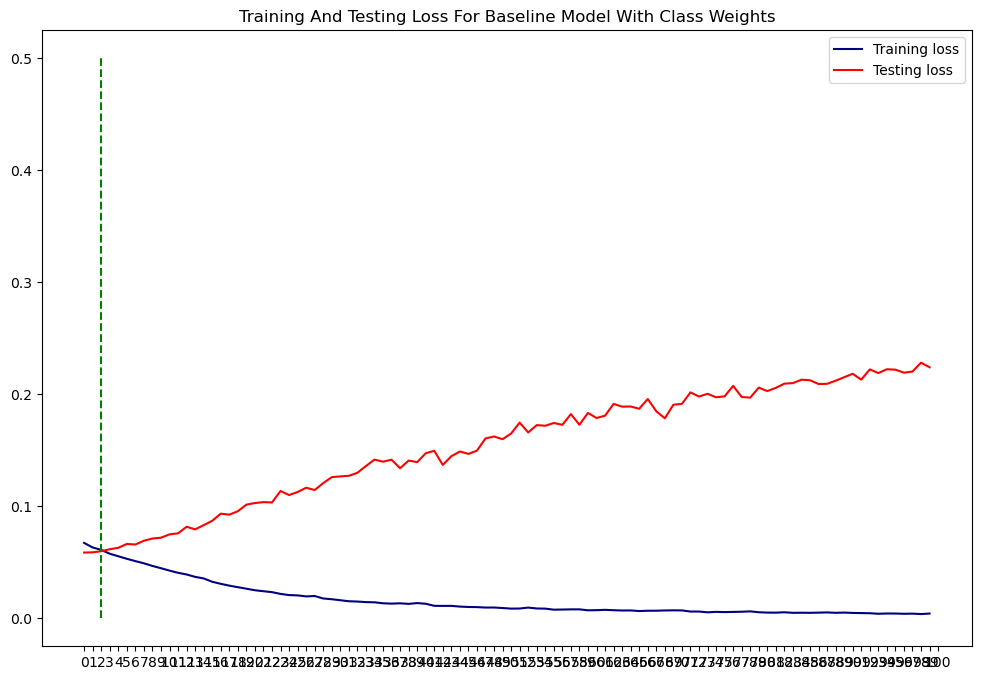

In [77]:
train_loss = history_class_weights['loss']
test_loss = history_class_weights['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.vlines(x=2, ymin=0, ymax=0.5, color='green', linestyle='--')
plt.title('Training and Testing Loss for Baseline Model with Class Weights'.title())
plt.legend()
plt.xticks(range(0, 101, 1))
plt.savefig('../charts/baseline_model_class_weights_loss.png', bbox_inches='tight')
plt.show()

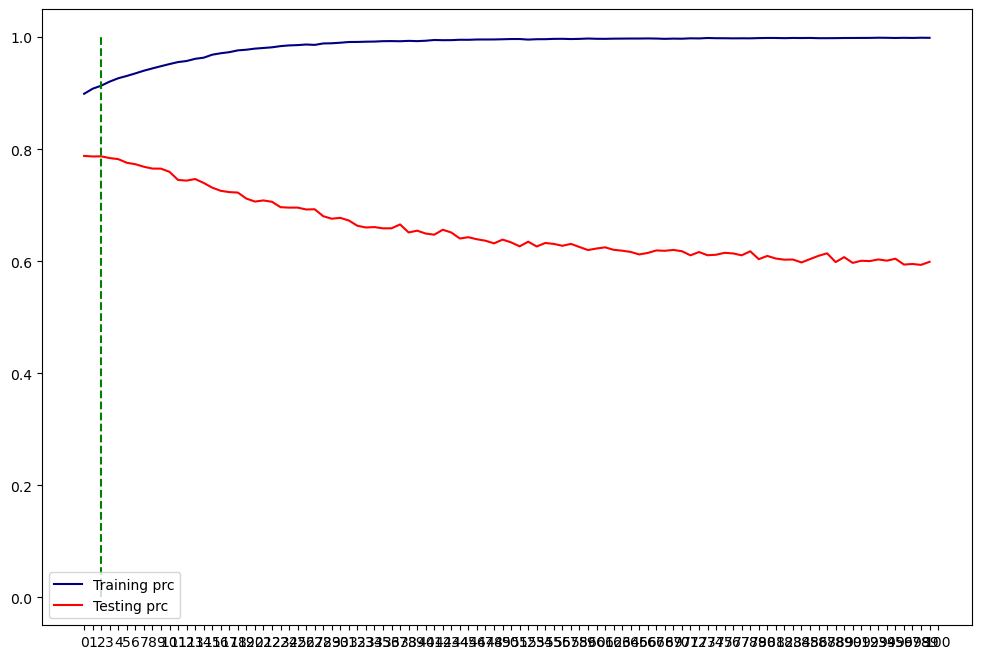

In [79]:
train_loss = history_class_weights['prc']
test_loss = history_class_weights['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training prc', color='navy')
plt.plot(test_loss, label='Testing prc', color='red')
plt.vlines(x=2, ymin=0, ymax=1.0, color='green', linestyle='--')
plt.legend()
plt.xticks(np.arange(0, 101, 1))
plt.savefig('../charts/baseline_model_class_weights_prc.png', bbox_inches='tight')
plt.show()

In [111]:
# model = keras.models.load_model("../nn_models/baseline_model.h5")

## Model with epoch 2

This is determined from the convergence in the epoch loss in tensorboard.
The class weights used in the neural network seem to overfit the data, the neural network with the class weights will be used.

In [30]:
log_dir = "logs/fit/model_stop" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
model = nn_creation()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 50)                6050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [32]:
# EPOCHS = 20
# history_stop = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=1024, verbose=1, callbacks=[early_stopping, tensorboard_callback])

EPOCHS = 3
history_stop = model.fit(
    vectorized_X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(vectorized_X_test, y_test),
    batch_size=1024,
    verbose=1,
    # class_weight=class_weights,
    callbacks=[tensorboard_callback],
)

Epoch 1/3
109/110 [============================>.] - ETA: 0s - loss: 0.2025 - tp: 104.0000 - fp: 1702.0000 - tn: 643446.0000 - fn: 24444.0000 - accuracy: 0.9610 - precision: 0.0576 - recall: 0.0042 - auc: 0.6723 - prc: 0.0532

2022-10-15 09:23:09.436611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 11s 73ms/step - loss: 0.2024 - tp: 104.0000 - fp: 1702.0000 - tn: 643924.0000 - fn: 24464.0000 - accuracy: 0.9610 - precision: 0.0576 - recall: 0.0042 - auc: 0.6724 - prc: 0.0532 - val_loss: 0.1209 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 276702.0000 - val_fn: 10530.0000 - val_accuracy: 0.9633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8664 - val_prc: 0.3997
Epoch 2/3
109/110 [============================>.] - ETA: 0s - loss: 0.0825 - tp: 8238.0000 - fp: 2269.0000 - tn: 642895.0000 - fn: 16294.0000 - accuracy: 0.9723 - precision: 0.7840 - recall: 0.3358 - auc: 0.9434 - prc: 0.5981

2022-10-15 09:23:16.449980: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 63ms/step - loss: 0.0826 - tp: 8254.0000 - fp: 2271.0000 - tn: 643355.0000 - fn: 16314.0000 - accuracy: 0.9723 - precision: 0.7842 - recall: 0.3360 - auc: 0.9434 - prc: 0.5982 - val_loss: 0.0591 - val_tp: 6389.0000 - val_fp: 1609.0000 - val_tn: 275093.0000 - val_fn: 4141.0000 - val_accuracy: 0.9800 - val_precision: 0.7988 - val_recall: 0.6067 - val_auc: 0.9702 - val_prc: 0.7678
Epoch 3/3
110/110 [==============================] - 7s 64ms/step - loss: 0.0548 - tp: 15029.0000 - fp: 3354.0000 - tn: 642272.0000 - fn: 9539.0000 - accuracy: 0.9808 - precision: 0.8175 - recall: 0.6117 - auc: 0.9777 - prc: 0.7863 - val_loss: 0.0512 - val_tp: 6659.0000 - val_fp: 1463.0000 - val_tn: 275239.0000 - val_fn: 3871.0000 - val_accuracy: 0.9814 - val_precision: 0.8199 - val_recall: 0.6324 - val_auc: 0.9790 - val_prc: 0.8071


In [25]:
model.save('../nn_models/model_ep2.h5')

In [28]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_stop.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_ep2", 'w'))

AttributeError: 'dict' object has no attribute 'history'

In [34]:
history_stop = json.load(open("../nn_models/saved_history_ep2", 'r'))

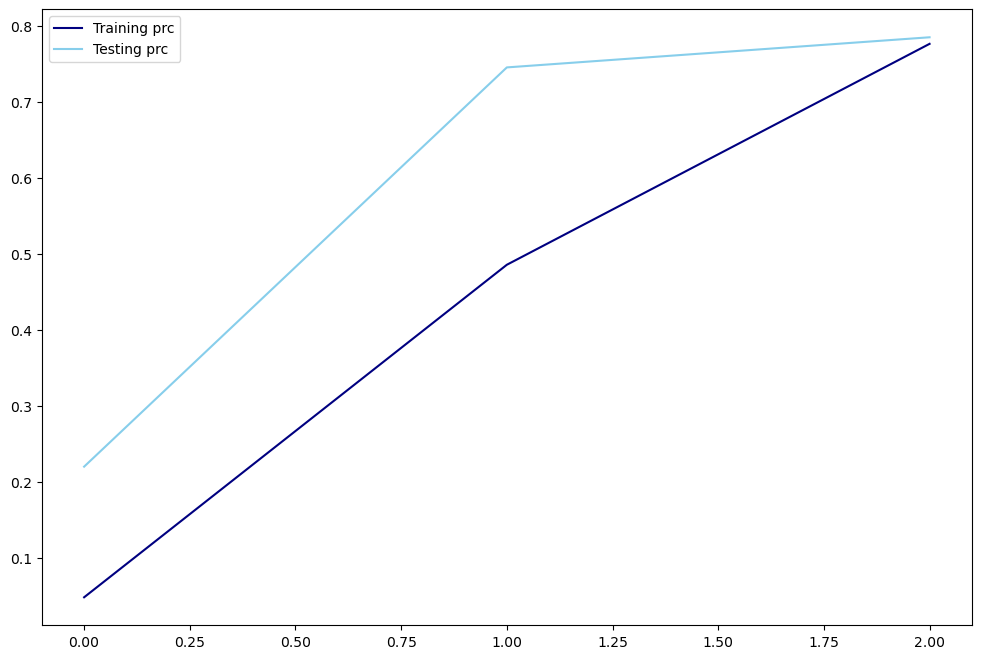

In [35]:
train_loss = history_stop['prc']
test_loss = history_stop['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training prc', color='navy')
plt.plot(test_loss, label='Testing prc', color='skyblue')
plt.legend();

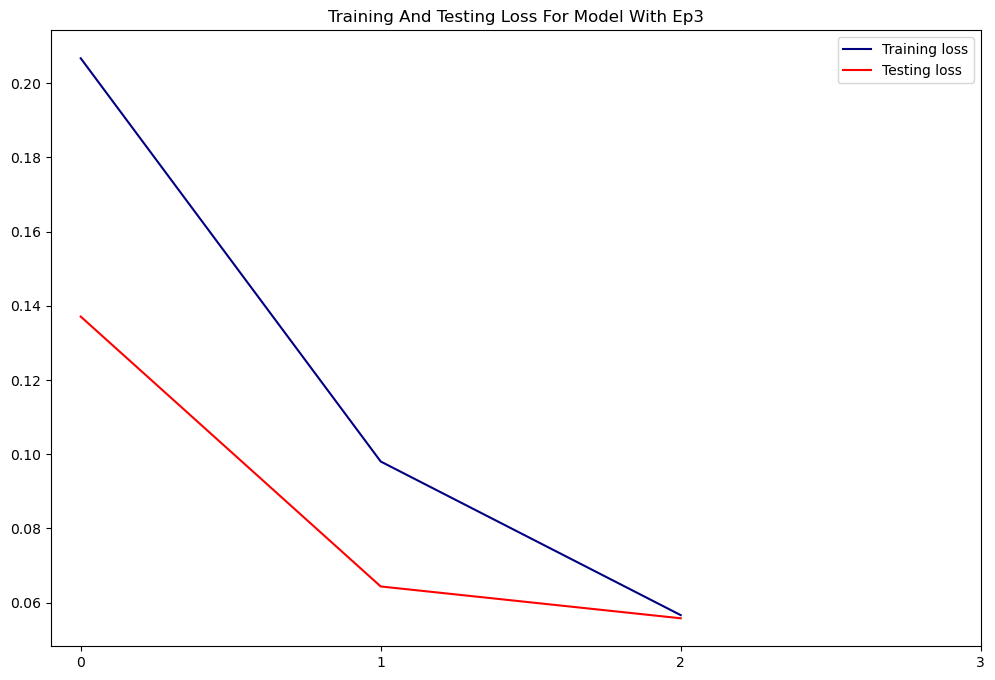

In [36]:
train_loss = history_stop['loss']
test_loss = history_stop['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.title('Training and Testing Loss for model with ep3'.title())
plt.legend()
plt.xticks(range(0, 4, 1))
plt.savefig('../charts/baseline_model_ep3_loss.png', bbox_inches='tight')
plt.show()

In [37]:
model = keras.models.load_model("../nn_models/model_ep2.h5")

In [45]:
# train_predictions_baseline = model.predict(vectorized_X_train, batch_size=1024)
# test_predictions_baseline = model.predict(vectorized_X_test, batch_size=1024)

y_pred = (model.predict(vectorized_X_test, batch_size=1024) > 0.5).astype("int32")

47/47 [==============================] - 1s 17ms/step


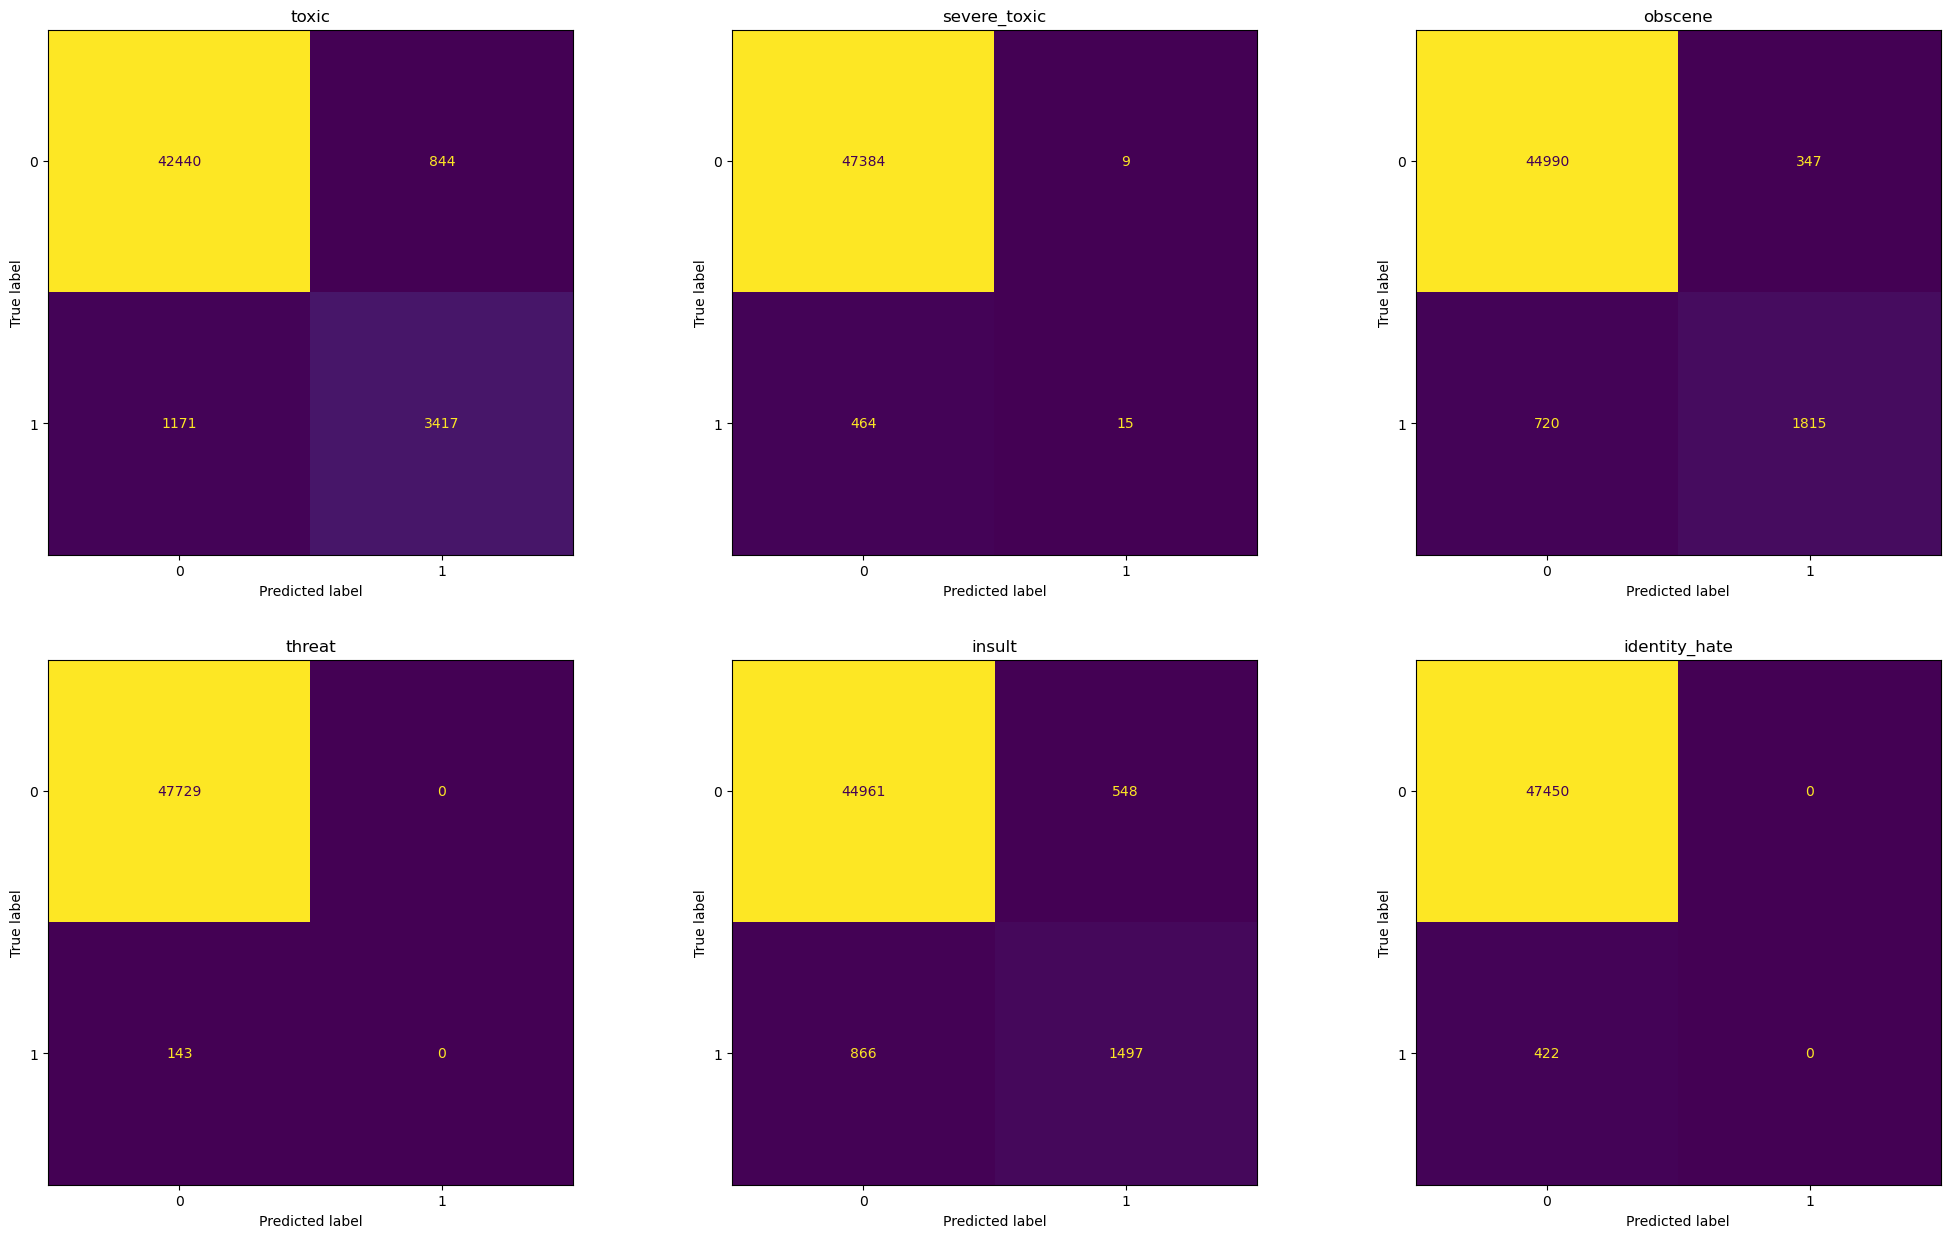

In [46]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

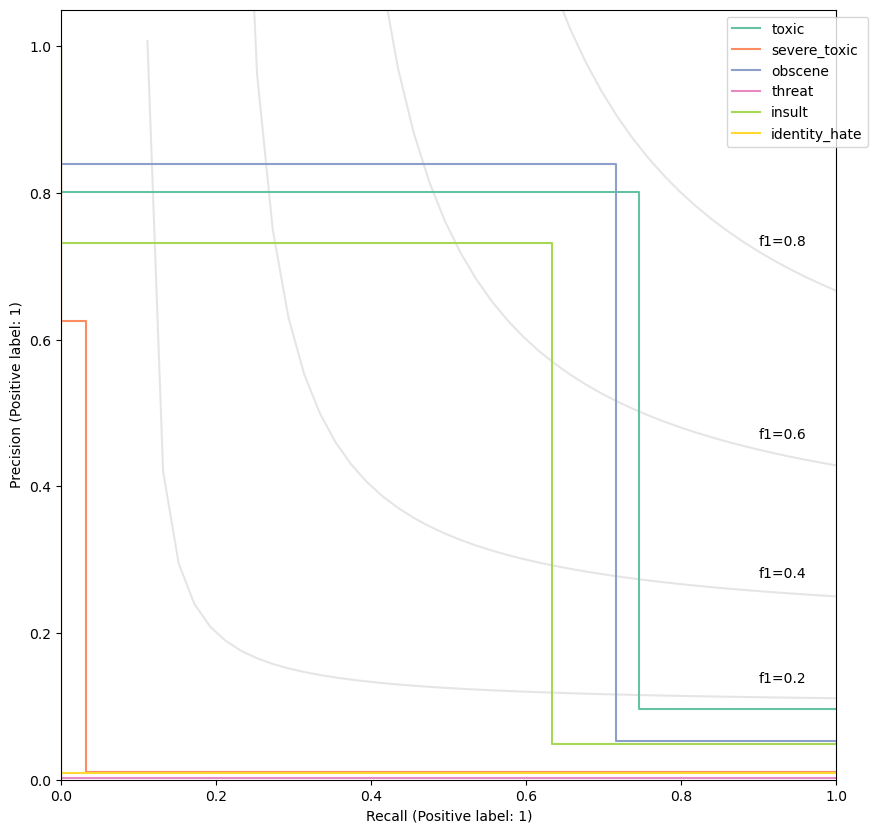

In [48]:
f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

In [47]:
model.evaluate(vectorized_X_test, y_test)

1496/1496 [==============================] - 12s 7ms/step - loss: 0.0558 - tp: 6744.0000 - fp: 1748.0000 - tn: 274954.0000 - fn: 3786.0000 - accuracy: 0.9807 - precision: 0.7942 - recall: 0.6405 - auc: 0.9726 - prc: 0.7851


[0.05577217787504196,
 6744.0,
 1748.0,
 274954.0,
 3786.0,
 0.980733335018158,
 0.7941592335700989,
 0.6404558420181274,
 0.9725923538208008,
 0.7850903868675232]

# Model with early stopping

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [53]:
log_dir = "logs/fit/model_early_stop" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [54]:
model = nn_creation()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 50)                6050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 6)                

In [55]:
# EPOCHS = 20
# history_stop = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=1024, verbose=1, callbacks=[early_stopping, tensorboard_callback])

EPOCHS = 50
history_stop = model.fit(
    vectorized_X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(vectorized_X_test, y_test),
    batch_size=1024,
    verbose=1,
    # class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stopping],
)

Epoch 1/50
110/110 [==============================] - 17s 87ms/step - loss: 0.2234 - tp: 896.0000 - fp: 11998.0000 - tn: 633628.0000 - fn: 23672.0000 - accuracy: 0.9468 - precision: 0.0695 - recall: 0.0365 - auc: 0.6393 - prc: 0.0515 - val_loss: 0.1387 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 276702.0000 - val_fn: 10530.0000 - val_accuracy: 0.9633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8080 - val_prc: 0.2159
Epoch 2/50
110/110 [==============================] - 8s 69ms/step - loss: 0.1040 - tp: 4198.0000 - fp: 1130.0000 - tn: 644496.0000 - fn: 20370.0000 - accuracy: 0.9679 - precision: 0.7879 - recall: 0.1709 - auc: 0.8993 - prc: 0.4355 - val_loss: 0.0635 - val_tp: 6120.0000 - val_fp: 1869.0000 - val_tn: 274833.0000 - val_fn: 4410.0000 - val_accuracy: 0.9781 - val_precision: 0.7661 - val_recall: 0.5812 - val_auc: 0.9719 - val_prc: 0.7408
Epoch 3/50
110/110 [==============================] - 7s 67ms/step - loss: 0.0544 - tp: 15685.0000 - fp: 4039.00

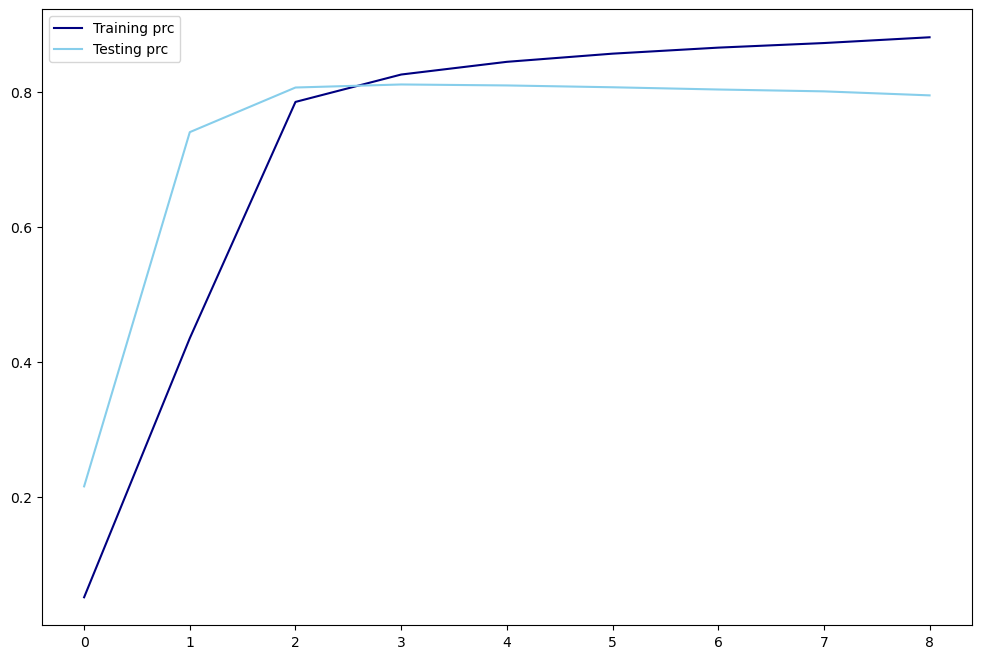

In [56]:
train_loss = history_stop.history['prc']
test_loss = history_stop.history['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training prc', color='navy')
plt.plot(test_loss, label='Testing prc', color='skyblue')
plt.legend();